In [1]:
import pandas as pd
import numpy as np
import csv
import unittest
import matplotlib.pyplot as plt
import math
from dateutil import parser
import re

# Tolerance formula

In [2]:
def tolerance_formula(N, e):
    '''
    Tolerance formula from Yang, p. 9
    '''
    print(N, e)
    return e <= N/np.log(N)

# Data file operations
This part of the code deals with file operations, such as reading and closing files

## Preferably use the final function!
Older ones are kind of deprecated

In [3]:
def save_data(filename, df):
    """
    Code from: https://www.kite.com/python/answers/how-to-save-a-pandas-dataframe-in-python
    """
    df.to_pickle(filename)


def read_data(filename):
    """
    Code from: https://www.kite.com/python/answers/how-to-save-a-pandas-dataframe-in-python
    """
    return pd.read_pickle(filename)

In [4]:
def append_representation_to_dataframe(df):
    '''
    Appends the syllable representations of the model and realization to the dataframe 
    to have all information in one place
    
    df: data set, of which the representations need to be appended
    
    No return, as it mutates the df object
    '''
    df['rep_model'] = df.model.apply(build_syllable_representation)
    df['rep_realization'] = df.realization.apply(build_syllable_representation)
    #print(df)

In [5]:
def write_nonmatches_to_csv(filename, df, comparison, header = ['Name', 'Age', 'word', 'model','realization','stressmodel','stressrealization'], apply_filter=True):
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write the data
        for n, a, word, w,v in collect_nonmatches_metadata(df, comparison):
            if not apply_filter:
                writer.writerow([n,a,word,w, v, build_syllable_representation(w), build_syllable_representation(v)])
            else:
                rep_w = build_syllable_representation(w)
                rep_v = build_syllable_representation(v)
                # If at least one of the two representations has 2 or more syllables, then we are interested
                if len(rep_w) >= 2 or len(rep_v) >= 2: 
                    writer.writerow([n,a,word,w, v, rep_w, rep_v])

In [6]:
def write_stats_to_csv(filename, a,b,c,d,e):
    '''
    stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act
    '''
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(['number','modellengthall','realizationlengthall','lengthmatch', 'modellengthnonmatch', 'realizationlengthnonmatch'])

        # write the data
        for i in range(10):
            writer.writerow([i, a[i], b[i], c[i], d[i], e[i]])

In [7]:
def write_df_to_csv(filename, df):
    df.to_csv(filename)

# Word class

In [8]:
class Word:
    def __init__(self, written, model, realization, rep_model, rep_realization):
        self.written = written
        self.model = model
        self.realization = realization
        self.rep_model = rep_model
        self.rep_realization = rep_realization
    
    def __eq__(self, other):
        return self.written == other.written
    
    def __hash__(self):
        return self.written.__hash__()

    def is_bisyl(self):
        return len(self.rep_model) == 2
    
    def is_iambic_bisyl(self):
        if len(self.rep_model) == 2:
            return self.rep_model[1]
        else:
            return False 
    
    def is_final_syllable_heavy(self):
        if self.model[-1] in ipa_vowels:
            # if the last letter is a vowel, we only have a heavy syllable if it is a diphtong, so if the letter before it is also a vowel
            return self.model[-2] in ipa_vowels
        else: #so final letter in agnostic_symbols or consonants
            return True
    
    def matches_pattern(self, pattern, model = True):
        '''
        Calculates whether the word matches the stress pattern
        
        pattern: string of F(alse) and T(rue) or A(gnostic) indicating the stress placement
        model: boolean which indicates whether to match to the model representation (True) or realization representation (False)
        Agnostic (or any other symbol) can be used to indicate that one does not care about the stress placement
        
        return: 
        '''
        if model:
            word = self.rep_model
        else:
            word = self.rep_realization
        
        # Initial check for length match. If not equal, no point in persuing (and prevents out of bound errors later on)
        if len(pattern) != len(word):
            return False
        
        for i,c in enumerate(pattern):
            if c == 'T':
                if not word[i]:
                    return False
            if c == 'F':
                if word[i]:
                    return False
        return True

# Wordlist class

In [9]:
class WordList:
    
    def __init__(self, time ):
        '''
        time: the point in time to which this wordlist refers
        '''
        pass
        #self.time = time
        #self.wordlist
        
    def __cmp__(self, other):
        return cmp(self.age, other.age)
    
    def __lt__(self, other):
        return self.age < other.age
    
    def __repr__(self):
        return "%s with length %s" % (self.age, len(self.wordlist))
    
    def add_word(self, word):
        pass

    def add_prev_state_wordlist(prev_wordlist):
        for word in prev_wordlist.wordlist:
            self.add_word(word)
    
    def parse_age(self):
        numbers = re.findall('\d+', self.time)
        # the age in months with a approximation for the number of days
        return float(numbers[0])*12 + float(numbers[1]) + float(numbers[2])/31.0

In [10]:
class UniqueWordList(WordList):
    
    def __init__(self, time ):
        '''
        time: the point in time to which this wordlist refers
        '''
        self.time = time
        self.age = self.parse_age()
        self.wordlist = set()
    
    def add_word(self, word):
        self.wordlist.add(word)

In [11]:
class AllWordList(WordList):
    
    def __init__(self, time ):
        '''
        time: the point in time to which this wordlist refers
        '''
        self.time = time
        self.age = self.parse_age()
        self.wordlist = []    
    
    def add_word(self, word):
        self.wordlist.append(word)


# Child development class

In [12]:
class ChildDevelopment:
    
    def __init__(self, name):
        '''
        name: child's name (just for bookkeeping purposes)
        '''
        self.name = name
        self.wordlists = []
        self.complete_wordlists = []
    
    
    def add_wordlist(self, wordlist, complete = False):
        '''
        Appends wordlist to the wordlists of the child
        
        wordlist: the wordlist to be added
        '''
        if not complete:
            self.wordlists.append(wordlist)
        else: 
            self.complete_wordlists.append(wordlist)

    def collect_ages(self):
        '''
        Collects all the ages of the different wordlists and saves in ages attribute
        '''
        self.ages = []
        for wordlist in self.complete_wordlists:
            self.ages.append(wordlist.age)
        
    def calculate_total_vocab_dev(self):
        '''
        Calculates the development of the vocabulary size, i.e. how the vocabulary grows through time
        
        returns: list of cumulative vocabulary sizes
        
        Todo: Add something similar for the dates so that we have those
        '''
        print(self.wordlists[0])
        development = []
        total_wordlist = set()
        for wordlist in self.wordlists:
            
            for word in wordlist.wordlist:
                total_wordlist.add(word)
            development.append(len(total_wordlist))
        return development

    
    def calculate_development_by_patterns(self, patterns):
        '''
        Calculates the wordlists for a list of patterns and the total development
        For efficiency, this is done at once (building wordlists is expensive)
        
        patterns: the patterns one wants the developments of
        return: list of developments for the patterns
        '''
        developments_counts = {}
        developments = {}
        
        for p in patterns:
            developments[p] = set()
            developments_counts[p] = []
        
        
        for wordlist in self.wordlists:
            for word in wordlist.wordlist:
                for p in patterns:
                    if word.matches_pattern(p):
                        developments[p].add(word)
            for p in patterns:
                developments_counts[p].append(len(developments[p]))
        
        return developments_counts, developments
        
    def calculate_progress_of_patterns_old(self, goal_patterns, real_patterns):
        '''
        Calculates, through time, how certain 
        
        TODO: fix that if you give two of the same pattern, the counts doubles
        Idea: instead of separate goal_pattern, make real_patterns linked to goal_pattern so no
        need to fill in same goal pattern twice
        '''
        goal_counts = {}
        real_counts = {}
        
        for i, p in enumerate(goal_patterns):
            goal_counts[p] = np.zeros(len(self.complete_wordlists))
            real_counts[real_patterns[i]] = np.zeros(len(self.complete_wordlists))
        
        for j, wordlist in enumerate(self.complete_wordlists):
            for word in wordlist.wordlist:
                for i, p in enumerate(goal_patterns):
                    # loop through the goal_patterns and count how many of those occurred in the data set
                    # Then count how many of them had the real_pattern as well
                    
                    if word.matches_pattern(p):
                        goal_counts[p][j] += 1
                        if word.matches_pattern(real_patterns[i], model = False): # If realizations matches the corresponding real pattern
                            real_counts[real_patterns[i]][j] += 1
                            
        return goal_counts, real_counts
    
    def calculate_progress_of_patterns(self, patterns):
        '''
        Calculates, through time, how certain 
        
        TODO: fix that if you give two of the same pattern, the counts doubles
        Idea: instead of separate goal_pattern, make real_patterns linked to goal_pattern so no
        need to fill in same goal pattern twice
        '''
        #iamb_bisyl_phases = 
        #patterns = {'FT': ['T', 'TF', 'TT', 'FT', 'AA']}
        
        # Goal structure:
        # dictionary:
        # { 'FT' :  ([], {'T': [], 'TF': [] } ),
        #   'TF' :  ([], {'T': [], 'TF': [] } )
        # }
        
        counts = {}
        
        for p in patterns:
            counts[p] = (np.zeros(len(self.complete_wordlists)), {})
            for rp in p:
                counts[p][1][rp] = np.zeros(len(self.complete_wordlists))
        
        #for 
        
        for j, wordlist in enumerate(self.complete_wordlists):
            for word in wordlist.wordlist:
                for p in patterns:
                    # loop through the patterns and count how many of those occurred in the data set
                    # Then count how many of them had the real_pattern as well
                    
                    if word.matches_pattern(p):
                        counts[p][0][j] += 1
                        for real_pat in patterns[p]:
                            if word.matches_pattern(real_pat, model = False): # If realizations matches the corresponding real pattern
                                counts[p][1][real_pat][j] += 1
                            
        return counts
    
    
    def determine_tolerance(self, total, exceptions):
        '''
        
        '''
        tolerance = []
        for i in range(len(total)):
            tolerance.append(tolerance_formula(total[i], exceptions[i]))
        print(tolerance)
        
    
    def plot_vocab_dev_bisyl(self):
        development_bisyl, development_bisyl_iamb = self.calculate_bisyl_vocab_dev()
        total_dev = self.calculate_total_vocab_dev()
        
        self.determine_tolerance(development_bisyl, development_bisyl_iamb)
        
        plt.plot(self.ages, total_dev, label='Total vocabulary')
        plt.plot(self.ages, development_bisyl, label='Bisyllabic words')
        plt.plot(self.ages, development_bisyl_iamb, label='Bisyllabic iambic words')
        plt.title('Development of ' + self.name)
        plt.legend()
        plt.show()
    
    
    def plot_vocab_dev(self, patterns):
        developments_counts, developments = self.calculate_development_by_patterns(patterns)
        total_dev = self.calculate_total_vocab_dev()
        
        #self.determine_tolerance(development_bisyl, development_bisyl_iamb)
        
        plt.plot(self.ages, total_dev, label='Total vocabulary')
        for p in patterns:
            plt.plot(self.ages, developments_counts[p], label=p)
        plt.title('Development of ' + self.name)
        plt.legend()
        plt.show()
    
    def build_complete_wordlists(self, df):
        '''
        fills the complete_wordlists attribute based on the words in df
        
        df: the complete dataframe (with representations)
        '''
        df_child = df[df['Name'] == self.name]
        indices = df[df['Name'] == self.name].index
        prev_time = df_child.at[indices[0],'Age']
        wordlist = AllWordList(prev_time)
        for index, data_point in df_child.iterrows(): # Might be slow, see https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
            #print(data_point)
            time = data_point['Age']
            if prev_time != time: 
                self.add_wordlist(wordlist, complete = True)
                wordlist = AllWordList(time)

            word = Word(data_point['word'], data_point['model'], data_point['realization'], data_point['rep_model'], data_point['rep_realization'])
            wordlist.add_word(word)

            prev_time = time
        self.complete_wordlists.sort()
        
        #This line should be somewhere else, make sure to call if after making wordlists
        self.collect_ages()

In [13]:
def build_wordlists_for_child(name, df):
    '''
    builds the child development object and fills it with word lists through time
    Assumes df is not shuffled (i.e. that the words from the same time point are next to each other)
    
    name: child name
    df: complete dataframe
    returns: child development object
    
    TODO: Maybe move to __init__ of child
    '''
    df_child = df[df['Name'] == name]
    indices = df[df['Name'] == name].index
    print(df_child)
    prev_time = df_child.at[indices[0],'Age']
    child_dev = ChildDevelopment(name)
    wordlist = UniqueWordList(prev_time)
    for index, data_point in df_child.iterrows(): # Might be slow, see https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
        #print(data_point)
        time = data_point['Age']
        if prev_time != time: 
            child_dev.add_wordlist(wordlist)
            wordlist = UniqueWordList(time)
        
        word = Word(data_point['word'], data_point['model'], data_point['realization'], data_point['rep_model'], data_point['rep_realization'])
        wordlist.add_word(word)
        
        prev_time = time
    child_dev.wordlists.sort()
    return(child_dev)

# Processing functions

In [14]:
ipa_vowels = ['a', 'ɑ', 'œ', 'æ', 'y', 'o', 'ɑ̈', 'i', 'u', 'ɪ', 'ə', 'ɛ', 'e', 'ɔ', 'ʌ', 'ø̈', 'ɛ̝','ʉ', 'œ̞', 'œ', 'ɛ̞', 'ʔ', 'ɒ','ø', 'æ̝', 'ə̆', 'o͡', 'o̝', 'ʊ', 'ɯ']#, '͡'] 
agnostic_symbols = ['͡', 'ː', 'ˑ'] # symbols that can either be a vowel or consonant

In [15]:
def build_syllable_representation(word, secondary=False):
    """
    word: the word of which you want the syllable representation
    
    Returns the representation of the syllable in the form of a list of booleans, where true represents stressed and false unstressed
    """
    if not isinstance(word, str):
        return []
    
    representation = []
    stressed = False
    vowels = False
    for c in list(word):
        #print(c)
        if secondary and (c == "ˈ" or c == "ˌ"):
            stressed = True
        elif not secondary and c == "ˈ":
            stressed = True
        elif c in ipa_vowels:
            if not vowels:
                vowels = True
                representation.append(stressed)
                stressed = False
        elif c not in agnostic_symbols: #if we do not know whether something is a vowel or consonant, we leave it be. If it is not a vowel and not agnostic, we have a consonant
            vowels = False
    return representation

In [16]:
def stringify_representation(representation):
    '''
    representation: list of booleans (representing stress pattern
    
    returns: string of the stress pattern
    '''
    string = ""
    for boolean in representation: 
        if boolean:
            string += 'T'
        else:
            string += 'F'
    return string


## Functions of which it is unclear whether they are still useful

In [17]:
def compare_realization_model(model, realization):
    '''
    
    '''
    assert(len(model) == len(realization))
    
    comparison = []
    unequal_lengths = []
    for i in np.arange(len(model)):
        mod_word = build_syllable_representation(model[i])
        act_word = build_syllable_representation(realization[i])
        if len(mod_word) != len(act_word):
            #print("not equal length", i, mod_word, act_word)
            unequal_lengths.append(i)
            comparison.append(False)
            continue
        problem_encountered = False
        for j in np.arange(len(mod_word)):
            if mod_word[j] != act_word[j]:
                problem_encountered = True
                continue
        comparison.append(not problem_encountered)
    return comparison, unequal_lengths

In [18]:
def collect_nonmatches_metadata(df, comparison):
    '''
    Finds the non matches within the data set and puts the model and the realization next to each other
    
    df: data set
    comparison: list of booleans that where true is a match and false is not a match
    
    returns a list of five-tuples of non-matching syllable structures preceded by the meta-data
    '''
    cases = []
    for i, boolean in enumerate(comparison):
        if not boolean:
            cases.append((df.Name[i], df.Age[i], df.word[i], df.model[i], df.realization[i]))
    return cases

In [19]:
def collect_nonmatches(df, comparison):
    '''
    Finds the non matches within the data set and puts the model and the realization next to each other
    
    df: data set
    comparison: list of booleans that where true is a match and false is not a match
    
    returns a list of pairs of non-matching syllable structures
    '''
    cases = []
    for i, boolean in enumerate(comparison):
        if not boolean:
            cases.append((df.model[i], df.realization[i]))
    return cases

In [20]:
def statistics(df, comparison, save=False):
    '''
    Calculates statistics on the syllable structure of the dataset 
    
    df: the data frame on which the statistics need to be calculated
    comparison: the list of booleans where true indicates model and realization match, and false that they do not match
    save: optional argument on whether to save the statistics to a csv file
    
    returns five dictionaries with statistics
    TODO TODO TODO 
    '''
    stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act = {}, {}, {}, {}, {}
    for i in np.arange(10):
        stats_mod[i] = 0
        stats_act[i] = 0
        stats_match[i] = 0
        stats_nonmatch_mod[i] = 0
        stats_nonmatch_act[i] = 0
    #print(comparison)
    for i, boolean in enumerate(comparison):
        rep_mod = build_syllable_representation(df.model[i])
        rep_act = build_syllable_representation(df.realization[i])
        stats_mod[len(rep_mod)] += 1
        stats_act[len(rep_act)] += 1
        if boolean:
            stats_match[len(rep_mod)] += 1
        else:
            stats_nonmatch_mod[len(rep_mod)] += 1
            stats_nonmatch_act[len(rep_act)] += 1
    #print(stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act)
    if save:
        write_stats_to_csv('stats.csv', stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act)
    return stats_mod, stats_act, stats_match, stats_nonmatch_mod, stats_nonmatch_act

In [21]:
def filter_iambic_bisyllabic_words(df):
    filter_bisyl = [True if l==2 else False for l in df.rep_model.apply(len) ]#df.rep_model.apply(len) #and df.rep_model[1]
    #print(filter_iamb)
    filtered = df[filter_bisyl]
    filter_iamb = [r[1] for r in filtered.rep_model]
    return filtered[filter_iamb] #Second thing returns booleans, we are interested when these are True
    
def filter_trisyllabic_words(df):
    filter_trisyl = [True if l==3 else False for l in df.rep_model.apply(len) ]#df.rep_model.apply(len) #and df.rep_model[1]
    #print(filter_iamb)
    return df[filter_trisyl]

def add_heavy_fin_syl_column(df):
    df['heavy_final_syl'] = df.model.apply(is_final_syllable_heavy)


In [22]:
def iambic_bysyl_investigation():
    iamb_bisyl = filter_iambic_bisyllabic_words(df)
    add_heavy_fin_syl_column(iamb_bisyl)
    print(iamb_bisyl)
    print(np.sum(iamb_bisyl.heavy_final_syl))
    print(iamb_bisyl[ [not b for b in iamb_bisyl.heavy_final_syl] ])

#write_df_to_csv('iamb_bisyl.csv', filter_iambic_bisyllabic_words(df))


def trisyl_investigation(df):
    # main function to collect trisyllabic words
    df_trisyl = filter_trisyllabic_words(df)
    write_df_to_csv('trisyl.csv', df_trisyl)
    df_trisyl_unique = df_trisyl.drop_duplicates(subset = ["word"])
    write_df_to_csv('trisyl_unique.csv', df_trisyl_unique)

# Legacy code

In [23]:
def is_final_syllable_heavy(word):
    '''
    DEPRECATED, JUST HERE TO MAKE THE TESTING CLASS HAPPY
    Use the function in the Word class instead
    '''
    if word[-1] in ipa_vowels:
        # if the last letter is a vowel, we only have a heavy syllable if it is a diphtong, so if the letter before it is also a vowel
        return word[-2] in ipa_vowels
    else: #so final letter in agnostic_symbols or consonants
        return True

# Calculate how many words of different types there are
Produces list of the different word type patterns and their occurences

In [24]:
def collect_unique_words(df):
    '''
    Collects all unique words in the data set
    
    df: complete data set including representations
    returns: set of words (in IPA)
    '''
    words = set()
    for word in df['model']:
        words.add(word)
    return words

def make_df_words_repr(words):
    '''
    Make new dataframe with just the words (in IPA) and the representation
    
    words: set of words (in IPA)
    returns: dataframe with word and repr of word
    '''
    df = pd.DataFrame(columns=['word','representation'])
    for word in words:
        df = df.append({'word': word, 'representation': build_syllable_representation(word)}, ignore_index=True)
    return df

def calculate_nr_word_types(df):
    '''
    calculates the number of occurrences of each word type
    
    df: dataframe with word (in IPA) and stringified representation
    returns: counts of the representation
    '''
    # Lists are not hashable, so we stringify the list representation, which is hashable
    strings = df['representation'].apply(stringify_representation)
    return strings.value_counts()

In [25]:
def word_type_investigation():
    words = collect_unique_words(df)
    words_reprs = make_df_words_repr(words)
    counts = calculate_nr_word_types(words_reprs)
    print(counts)

# Test cases

In [26]:
class MyTest(unittest.TestCase):
    def test_build_syllable_representation(self, secondary=False):
        '''
        Tests the build_syllable_representation function with different examples
        Also used to see if something breaks after adjusting
        '''
    
        if not secondary:
            #one syllable word, with bridge
            self.assertEqual([True], build_syllable_representation('ˈbu̠t͡s'))
            
            #simple two syllable words with different stress
            self.assertEqual([False, True], build_syllable_representation('koːˈlɛin'))
            self.assertEqual([True, False], build_syllable_representation('ˈpukə'))
            self.assertEqual([True, False], build_syllable_representation('ˈɡʊkʊk'))
            
            #other
            self.assertEqual([True, False, False], build_syllable_representation('ˈʔaːˌkleːdə'))
            
            self.assertEqual([True, False], build_syllable_representation('ˈpinoːŭ'))
            self.assertEqual([True, False, False], build_syllable_representation('ˈzeˌot͡jɑ̈s'))
            self.assertEqual([True, False], build_syllable_representation('ˈnæˑŋi'))
            
            
            

    def test_is_final_syllable_heavy(self):
        self.assertEqual(True, is_final_syllable_heavy('ˈzeˌot͡jɑ̈s'))
        self.assertEqual(True, is_final_syllable_heavy('koːˈlɛin'))
        self.assertEqual(True, is_final_syllable_heavy('koˈnɛi'))
        self.assertEqual(False, is_final_syllable_heavy('ˈpukə'))
        self.assertEqual(True, is_final_syllable_heavy('ˈbu̠t͡s'))
        self.assertEqual(True, is_final_syllable_heavy('kˈɑpχː'))
        self.assertEqual(True, is_final_syllable_heavy('neː'))
        self.assertEqual(True, is_final_syllable_heavy('fiˈjoʋ'))

# Reproduce tables from Fikkert

In [27]:
def reproduce_tables(df, children_names):
    '''
    Reproduces the data from the tables from Fikkert, p. 25
    That is, function calculates the total amount of model bisyllabic words and calculates 
    the percentage that is realized in a truncated way, differentiating between iambic and
    trochaic words. 
    
    df: the complete data from with representations
    children_names: the names of the children for which the calculations need to be done
    returns: dictionary with the child names and the totals of model bisyllabic words and truncated forms
    '''
    data_per_child = {}
    for child in children_names:
        ch_data = df[df['Name'] == child]
        #print(ch_data)
        total_bisyl_iamb = 0
        total_bisyl_troc = 0
        trunc_bisyl_iamb = 0
        trunc_bisyl_troc = 0
        for index, data_point in ch_data.iterrows(): 
            if len(data_point['rep_model'])== 2:
                #if not data_point['rep_model'][0] and data_point['rep_model'][1]:
                if data_point['rep_model'][1]:
                    total_bisyl_iamb += 1
                    if len(data_point['rep_realization']) == 1:
                        trunc_bisyl_iamb += 1
                #if data_point['rep_model'][0] and not data_point['rep_model'][1]:
                if data_point['rep_model'][0]:
                    total_bisyl_troc += 1
                    if len(data_point['rep_realization']) == 1:
                        trunc_bisyl_troc += 1
        data_per_child[child] = (total_bisyl_iamb, total_bisyl_troc, trunc_bisyl_iamb, trunc_bisyl_troc)
    return data_per_child

def pretty_print_tables(data_per_child, children_names):
    '''
    Prints the percentages of truncated bisyllabic trochees and iambs
    
    data_per_child: dictionary with the child names and the totals of model bisyllabic words and truncated forms
    children_names: the names of the children for which the data needs to be printed
    
    '''
    for child in children_names:
        data = data_per_child[child]
        print(child, ":")
        print( (data[3]/data[1])*100 ) 
        print( (data[2]/data[0])*100 ) #trunc iamb divided by total iamb

In [28]:
def run_reproduce_tables():
    '''
    Reproduces the tables from Fikkert p. 25
    '''
    children_names = ['Catootje', 'David', 'Elke', 'Enzo', 'Eva', 'Jarmo', 'Leon', 'Leonie', 'Noortje', 'Robin', 'Tirza', 'Tom']
    child_per_data = reproduce_tables(df, children_names)
    pretty_print_tables(child_per_data, children_names)

# Phase development

This part of the code goes through the phase development of the children

## Phase 1

In phase 1, the child truncates the bisyllabic word and produces it as monosyllabic. Only the stressed syllable of the adult target is produced.

In [29]:
def calc_phase_1_dev(child, patterns):
    goal_counts, real_counts = child.calculate_progress_of_patterns(patterns)
    print(goal_counts)
    print(real_counts)

# Main

This section contains different mains that use the function above to extract (hopefully) useful data

In [30]:
# Run tests
test = MyTest()
test.test_build_syllable_representation()
test.test_is_final_syllable_heavy()

In [31]:
# Read data and add representation column to the data
#    Fikkert corpus/CLPF: data2.pkl
#    Grimm corpus: Grimm.pkl

df = read_data("data2.pkl")
append_representation_to_dataframe(df)
#print(df)
write_df_to_csv('CLPF.csv', df)

      Name               Age       word      model  realization  \
0     Leon  P1Y10M28DT0H0M0S  aankleden  ˈankledən  ˈʔaːˌkleːdə   
1     Leon  P1Y10M28DT0H0M0S        aap        ˈap         ˈʔap   
2     Leon  P1Y10M28DT0H0M0S      ander     ˈɑndəɹ        ˈʔɑnə   
3     Leon  P1Y10M28DT0H0M0S       auto       ˈoto       ʔɑˈtoː   
4     Leon  P1Y10M28DT0H0M0S        bal       ˈbɑl         ˈpɑl   
...    ...               ...        ...        ...          ...   
2553  Leon   P2Y0M10DT0H0M0S        wel       ˈʋɛl         ˈʋa̝   
2554  Leon   P2Y0M10DT0H0M0S        wel       ˈʋɛl        ˈʋʉ̹l   
2555  Leon   P2Y0M10DT0H0M0S        wel       ˈʋɛl        ˈʋɛ̝l   
2556  Leon   P2Y0M10DT0H0M0S        wel       ˈʋɛl         ˈʋɛə   
2557  Leon   P2Y0M10DT0H0M0S      zusje    ˈzœs͡jə       ˈsʉʃ̟ə   

                 rep_model       rep_realization  
0     [True, False, False]  [True, False, False]  
1                   [True]                [True]  
2            [True, False]         [True, 

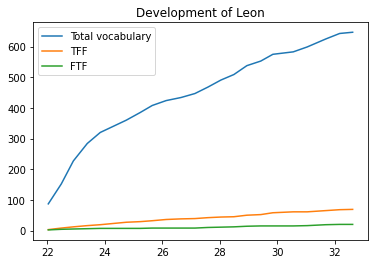

None
[22.032258064516128 with length 131, 22.483870967741936 with length 161, 22.903225806451612 with length 184, 23.387096774193548 with length 148, 23.838709677419356 with length 158, 24.741935483870968 with length 119, 25.225806451612904 with length 124, 25.64516129032258 with length 86, 26.129032258064516 with length 88, 26.64516129032258 with length 52, 27.129032258064516 with length 73, 27.580645161290324 with length 72, 28.032258064516128 with length 79, 28.483870967741936 with length 75, 28.93548387096774 with length 125, 29.419354838709676 with length 74, 29.838709677419356 with length 96, 30.548387096774192 with length 56, 31.032258064516128 with length 94, 31.677419354838708 with length 169, 32.16129032258065 with length 153, 32.61290322580645 with length 94]
22.032258064516128 with length 131


In [32]:
# Plot the vocabulary development of a specific child

def investigate_child_development(name):
    '''
    TODO: needs to be adjusted for the patterns and such
    '''
    child = build_wordlists_for_child(name, df)
    #print(leon.wordlists[0])
    child.calculate_total_vocab_dev()

leon = build_wordlists_for_child('Leon', df)
#print(leon.wordlists[0])
leon.build_complete_wordlists(df)

print(leon.plot_vocab_dev(['TFF', 'FTF']))
print(leon.complete_wordlists)
print(leon.complete_wordlists[0])

In [33]:
# Investigate what word types occur how often

word_type_investigation()

TF        1019
T          691
TFF        320
FTF        112
FT         104
TFFF        61
F           36
FFT         30
TTF         20
FFTF        19
TFTF        17
TT          14
FTFF        10
TFT          7
TFFFF        6
FFFT         5
FFTFF        4
TFFT         4
TFFTF        3
FFFF         2
FTFT         2
FTFTF        2
FF           2
FFFTTF       1
FFTFFF       1
TTFF         1
FFF          1
TFTFF        1
FTFFFF       1
             1
Name: representation, dtype: int64


In [34]:
# Run reproduction of tables
run_reproduce_tables()

Catootje :
6.0
12.087912087912088
David :
5.150214592274678
18.51851851851852
Elke :
11.080332409972298
85.45454545454545
Enzo :
8.401084010840108
30.0
Eva :
8.93371757925072
62.96296296296296
Jarmo :
12.063492063492063
68.57142857142857
Leon :
3.602305475504323
22.916666666666664
Leonie :
7.87037037037037
8.0
Noortje :
7.707910750507099
54.54545454545454
Robin :
6.122448979591836
37.03703703703704
Tirza :
6.432748538011696
57.49999999999999
Tom :
9.632224168126093
43.42105263157895


### Stages
- Stage 1: disyllables realized as monosyllabic
- Stage 2: both syllables realized, but stress on first syllable
- Stage 3: both syllables realized with equal stress
- Stage 4: adult like stress realization

In [35]:
iamb_bisyl_phases = ['T', 'TF', 'TT', 'FT', 'AA']
patterns = {'FT': iamb_bisyl_phases}
calc_phase_1_dev(leon, patterns)#['FT', 'FT', 'FT', 'FT', 'FT'], ['T', 'TF', 'TT', 'FT', 'AA'])

KeyError: 'TF'